In [1]:
import pandas as pd
import src.DataProcessing.read_data as rd

ruta = '../data/TABLAS ORDINARIOS CCTROLEBUS Vs11 20-10-2023-IMPR.xlsx'
hoja_c4_c6 = 'CONSOL C4-C6-L-V'
base = rd.lectura_tablas_c4_c6(ruta,hoja_c4_c6)
base = rd.transformacion_a_minutos(base)
base = base[base['CIRCUITO']=='C4'].reset_index(drop=True).drop("ORD",axis=1).reset_index()
base.columns = ["ORD","COD. OP.","CIRCUITO","SALIDA","LLEGADA"]
base['ORD'] = base['ORD']+1
base.head()


,ORD,COD. OP.,CIRCUITO,SALIDA,LLEGADA
0,1,1Q,C4,300.0,408.0
1,2,2Q,C4,307.0,415.0
2,3,3Q,C4,314.0,422.0
3,4,4Q,C4,321.0,429.0
4,5,5Q,C4,328.0,436.0


In [13]:
delta = 25 # Parametro de tolerancia
P = 40 # Parametro que indica longitud de pause

# Parametros para controlar tiempito minimo y máximo de espera
l1 = 2
u1 = 25

# Parámetros para controlar tiempo mínimo y máximo de descanso
l2 = P
u2 = P + delta 

# Parametros

break1 = 240
break2 = 670#720
break3 = 960
totalHorasTrabajadas =  1440

M_P = 5
M_T = 1440

b = base['LLEGADA']
b = {key+1:value for key,value in b.to_dict().items()}

a = base['SALIDA']
a = {key+1:value for key,value in a.to_dict().items()}

base = rd.creacion_arcos_A1_A2(base,l1,u1,l2,u2)
base

,ORD,COD. OP.,CIRCUITO,SALIDA,LLEGADA,Arcos-Costo,Arcos-Costo A1,Arcos-Costo A2
0,1,1Q,C4,300.0,408.0,"[(21.0, 5.0), (22.0, 13.0), (23.0, 23.0), (24....","[(21.0, 5.0), (22.0, 13.0), (23.0, 23.0)]","[(25.0, 43.0), (26.0, 53.0), (27.0, 63.0)]"
1,2,2Q,C4,307.0,415.0,"[(22.0, 6.0), (23.0, 16.0), (24.0, 26.0), (25....","[(22.0, 6.0), (23.0, 16.0)]","[(26.0, 46.0), (27.0, 56.0)]"
2,3,3Q,C4,314.0,422.0,"[(23.0, 9.0), (24.0, 19.0), (25.0, 29.0), (26....","[(23.0, 9.0), (24.0, 19.0)]","[(27.0, 49.0), (28.0, 59.0)]"
3,4,4Q,C4,321.0,429.0,"[(23.0, 2.0), (24.0, 12.0), (25.0, 22.0), (26....","[(23.0, 2.0), (24.0, 12.0), (25.0, 22.0)]","[(27.0, 42.0), (28.0, 52.0), (29.0, 62.0)]"
4,5,5Q,C4,328.0,436.0,"[(24.0, 5.0), (25.0, 15.0), (26.0, 25.0), (27....","[(24.0, 5.0), (25.0, 15.0), (26.0, 25.0)]","[(28.0, 45.0), (29.0, 55.0), (30.0, 65.0)]"
...,...,...,...,...,...,...,...,...
115,116,16Q,C4,1090.0,1205.0,[],[],[]
116,117,17Q,C4,1095.0,1210.0,[],[],[]
117,118,18Q,C4,1100.0,1215.0,[],[],[]
118,119,19Q,C4,1105.0,1220.0,[],[],[]


In [14]:
import numpy as np


# Unidades
M = len(base['COD. OP.'].unique()) 
M = 15
print('M: ',M)

capacidad = M

# Viajes 
N = base['ORD'].unique()
print('N: ',len(N))
N0 = np.insert(N, 0, 0)

# Creación del diccionario de costos
costos = {}
costos_A1 = {}
costos_A2 = {}
costos_inicio_fin = {}
for index,row in base.iterrows():
    costos_arcos_A1 = {(row['ORD'],int(i[0])):i[1] for i in row['Arcos-Costo A1']}
    costos_A1.update(costos_arcos_A1)
    
    costos_arcos_A2 = {(row['ORD'],int(i[0])):i[1] for i in row['Arcos-Costo A2']}
    costos_A2.update(costos_arcos_A2)
    
    costos_arcos = {(row['ORD'],int(i[0])):i[1] for i in row['Arcos-Costo']}
    costos.update(costos_arcos)
    
    costos_inicio_fin[(0,row['ORD'])] = 0
    costos_inicio_fin[(row['ORD'],len(N)+1)] = 0
    
costos.update(costos_inicio_fin)

arcos_A1 = costos_A1.keys()
arcos_A2 = costos_A2.keys()
arcos_unidades_A1 = []
arcos_unidades_A2 = []
arcos_unidades_inicio_fin = []

arcos_unidad_i_A1 = [(arco[0],arco[1],1) for arco in arcos_A1 if arco[0]!=0 and arco[1]!=(len(N)+1)]
arcos_unidades_A1 += arcos_unidad_i_A1

arcos_unidad_i_A2 = [(arco[0],arco[1],1) for arco in arcos_A2 if arco[0]!=0 and arco[1]!=(len(N)+1)]
arcos_unidades_A2 += arcos_unidad_i_A2

arcos_unidades_inicio = [(0,row['ORD'],1) for index,row in base.iterrows()]
arcos_unidades_fin = [(row['ORD'],len(N)+1,1) for index,row in base.iterrows()]
arcos_unidades_inicio_fin = arcos_unidades_inicio + arcos_unidades_fin    
    
print('A1',len(arcos_unidades_A1))
print('A2',len(arcos_unidades_A2))
print('Inicio-Fin',len(arcos_unidades_inicio_fin))
print('Inicio',len(arcos_unidades_inicio))
print('Fin',len(arcos_unidades_fin))

arcos = arcos_unidades_A1+arcos_unidades_A2+arcos_unidades_inicio_fin

indices_A1 = list(set([elemento for tupla in arcos_unidades_A1 for elemento in tupla]))

indices_A2 = list(set([elemento for tupla in arcos_unidades_A2 for elemento in tupla]))

M:  15
N:  120
A1 340
A2 344
Inicio-Fin 240
Inicio 120
Fin 120


In [15]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Lists to store the evolution of key metrics
gap_list = []
time_list = []
lower_bound_list = []
upper_bound_list = []

# Define the callback function
def my_callback(model, where):
    if where == gp.GRB.Callback.MIP:
        # Check if there's a feasible solution (best objective value exists)
        best_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        best_bound = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

        if best_obj < gp.GRB.INFINITY:
            # Compute the GAP only if best_obj is valid
            gap = abs(best_obj - best_bound) / (abs(best_obj) + 1e-10)  # Add a small value to avoid division by zero

            # Capture the time during the optimization
            current_time = model.cbGet(gp.GRB.Callback.RUNTIME)

            # Store the values
            gap_list.append(gap)
            lower_bound_list.append(best_bound)
            upper_bound_list.append(best_obj)
            time_list.append(current_time)


# Define and optimize your Gurobi model
model = gp.Model()


m3 = gp.Model('Asignacion-Flota-V1')
# Terminar al alcanzar un Gap del 10%
m3.Params.MIPGap = 0.10
m3.setParam('OutputFlag', 1)
# Enfocar estrategia en mejorar la cota dual
m3.Params.MIPFocus = 3
m3.Params.NoRelHeurTime = 30

# Fijar generación muy agresiva de cortes
m3.Params.Cuts = 1

# Terminar luego de 180 segundos
m3.Params.TimeLimit = 300

x = m3.addVars(arcos,vtype=GRB.BINARY,name='x')
z = m3.addVars(N,vtype=GRB.BINARY,name='z')


T = m3.addVars(N,vtype=GRB.INTEGER,name='T',ub=1440)
PV = m3.addVars(N,vtype=GRB.INTEGER,name='P',lb=0,ub=2)

#T[0].ub = 0
#PV[0].ub = 0

y0 = m3.addVars(N,vtype=GRB.BINARY,name='y1')
y1 = m3.addVars(N,vtype=GRB.BINARY,name='y2')
y2 = m3.addVars(N,vtype=GRB.BINARY,name='y3')


m3.setParam('LogFile', 'gurobi.log')

m3.setObjective(gp.quicksum(costos[i,j]*x[i,j,k] for i,j,k in arcos)+ 1000*z.sum('*') ,GRB.MINIMIZE)

m3.addConstrs((T[j] >= (b[j]-a[j]) - M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name='T_lower_inicio')
m3.addConstrs((T[j] <=  (b[j]-a[j]) + M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name='T_upper_inico ')

m3.addConstrs((PV[j]<= M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name = 'P_upper_inicio')
m3.addConstrs((PV[j]>= - M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name = 'P_lower_inicio')

m3.addConstrs((x.sum(n,'*','*') == 1 - z[n] for n in N), name=f"Constraints")
m3.addConstrs((x.sum('*',i,1)-x.sum(i,'*',1)==0 for i in N ),name=f'Conservacion')
m3.addConstr(x.sum(0,'*',1) <= capacidad, name=f"Capacidades")


m3.addConstrs((T[j] >= T[i] + (b[j]-b[i]) - M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='T_upper_A1')
m3.addConstrs((T[j] <= T[i] + (b[j]-b[i]) + M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='T_lower_A1')

m3.addConstrs((PV[j] >= PV[i] - M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='P_upper_A1')
m3.addConstrs((PV[j] <= PV[i] + M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='P_lower_A1')


m3.addConstrs((T[j] >= T[i] + (b[j]-b[i]) - M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='T_upper_A2')
m3.addConstrs((T[j] <= T[i] + (b[j]-b[i]) + M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='T_lower_A2')

m3.addConstrs((PV[j] >= PV[i] + 1 - M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='P_upper_A2')
m3.addConstrs((PV[j] <= PV[i] + 1 + M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='P_lower_A2')


m3.addConstrs((T[i]<= break1 - 0.5*P + delta+M_T*(1-y0[i]) for i in N), name = 'N1_Restriccion' )
m3.addConstrs((T[i] - (b[i]-a[i]) >= break1 + 0.5*P - delta-M_T*(1-y1[i]) for i in N), name = 'N2_Restriccion' )
m3.addConstrs((T[i]<= break2 - 0.5*P + delta+M_T*(1-y1[i]) for i in N), name = 'N3_Restriccion' )
m3.addConstrs((T[i] - (b[i]-a[i]) >= break2 + 0.5*P - delta-M_T*(1-y2[i]) for i in N), name = 'N4_Restriccion' )
m3.addConstrs((T[i]<= break3 + M_T*(1-y2[i]) for i in N), name = 'N4_Restriccion' )

m3.addConstrs((y0[n]+y1[n]+y2[n]==1 for n in N ),name='Aux1')
m3.addConstrs((y1[n]+2*y2[n]==PV[n] for n in N ),name='Aux2')


m3.write('Modelo.lp')


m3.optimize(my_callback)

# 16minutos ---> GAP: 72,5% | Cota Inf: 9557 | Best Value: 34711

Set parameter MIPGap to value 0.1
Set parameter MIPFocus to value 3
Set parameter NoRelHeurTime to value 30
Set parameter Cuts to value 1
Set parameter TimeLimit to value 300
Set parameter LogFile to value "gurobi.log"
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.3.0 22D68)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 4297 rows, 1644 columns and 13740 nonzeros
Model fingerprint: 0x29f4bf8e
Variable types: 0 continuous, 1644 integer (1404 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 120000.00000
Presolve removed 886 rows and 238 columns
Presolve time: 0.03s
Presolved: 3411 rows, 1406 columns, 11471 nonzeros
Variable types: 0 continuous, 1406 integer (1169 binary)
Found heuristic solution: objective 105000.00000
Starting No

In [16]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Lists to store the evolution of key metrics
gap_list = []
time_list = []
lower_bound_list = []
upper_bound_list = []

# Define the callback function
def my_callback(model, where):
    if where == gp.GRB.Callback.MIP:
        # Check if there's a feasible solution (best objective value exists)
        best_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        best_bound = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

        if best_obj < gp.GRB.INFINITY:
            # Compute the GAP only if best_obj is valid
            gap = abs(best_obj - best_bound) / (abs(best_obj) + 1e-10)  # Add a small value to avoid division by zero

            # Capture the time during the optimization
            current_time = model.cbGet(gp.GRB.Callback.RUNTIME)

            # Store the values
            gap_list.append(gap)
            lower_bound_list.append(best_bound)
            upper_bound_list.append(best_obj)
            time_list.append(current_time)


# Define and optimize your Gurobi model
model = gp.Model()


m3 = gp.Model('Asignacion-Flota-V1')
# Terminar al alcanzar un Gap del 10%
m3.Params.MIPGap = 0.10
m3.setParam('OutputFlag', 1)
# Enfocar estrategia en mejorar la cota dual
m3.Params.MIPFocus = 3
m3.Params.NoRelHeurTime = 30

# Fijar generación muy agresiva de cortes
m3.Params.Cuts = 1

# Terminar luego de 180 segundos
m3.Params.TimeLimit = 300

x = m3.addVars(arcos,vtype=GRB.BINARY,name='x')
z = m3.addVars(N,vtype=GRB.BINARY,name='z')


T = m3.addVars(N,vtype=GRB.INTEGER,name='T',ub=1440)
PV = m3.addVars(N,vtype=GRB.INTEGER,name='P',lb=0,ub=2)

#T[0].ub = 0
#PV[0].ub = 0

y0 = m3.addVars(N,vtype=GRB.BINARY,name='y1')
y1 = m3.addVars(N,vtype=GRB.BINARY,name='y2')
y2 = m3.addVars(N,vtype=GRB.BINARY,name='y3')


m3.setParam('LogFile', 'gurobi.log')

m3.setObjective(gp.quicksum(costos[i,j]*x[i,j,k] for i,j,k in arcos)+ 1000*z.sum('*') ,GRB.MINIMIZE)

m3.addConstrs((T[j] >= (b[j]-a[j]) - M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name='T_lower_inicio')
m3.addConstrs((T[j] <=  (b[j]-a[j]) + M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name='T_upper_inico ')

m3.addConstrs((PV[j]<= M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name = 'P_upper_inicio')
m3.addConstrs((PV[j]>= - M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_inicio),name = 'P_lower_inicio')

m3.addConstrs((x.sum(n,'*','*') == 1 - z[n] for n in N), name=f"Constraints")
m3.addConstrs((x.sum('*',i,1)-x.sum(i,'*',1)==0 for i in N ),name=f'Conservacion')
m3.addConstr(x.sum(0,'*',1) <= capacidad, name=f"Capacidades")


m3.addConstrs((T[j] >= T[i] + (b[j]-b[i]) - M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='T_upper_A1')
m3.addConstrs((T[j] <= T[i] + (b[j]-b[i]) + M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='T_lower_A1')

m3.addConstrs((PV[j] >= PV[i] - M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='P_upper_A1')
m3.addConstrs((PV[j] <= PV[i] + M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A1 ),name='P_lower_A1')


m3.addConstrs((T[j] >= T[i] + (b[j]-b[i]) - M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='T_upper_A2')
m3.addConstrs((T[j] <= T[i] + (b[j]-b[i]) + M_T*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='T_lower_A2')

m3.addConstrs((PV[j] >= PV[i] + 1 - M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='P_upper_A2')
m3.addConstrs((PV[j] <= PV[i] + 1 + M_P*(1-x[i,j,k]) for i,j,k in arcos_unidades_A2 ),name='P_lower_A2')


m3.addConstrs((T[i]<= break1 - 0.5*P + delta+M_T*(1-y0[i]) for i in N), name = 'N1_Restriccion' )
m3.addConstrs((T[i] - (b[i]-a[i]) >= break1 + 0.5*P - delta-M_T*(1-y1[i]) for i in N), name = 'N2_Restriccion' )
m3.addConstrs((T[i]<= break2 - 0.5*P + delta+M_T*(1-y1[i]) for i in N), name = 'N3_Restriccion' )
m3.addConstrs((T[i] - (b[i]-a[i]) >= break2 + 0.5*P - delta-M_T*(1-y2[i]) for i in N), name = 'N4_Restriccion' )
m3.addConstrs((T[i]<= break3 + M_T*(1-y2[i]) for i in N), name = 'N4_Restriccion' )

m3.addConstrs((y0[n]+y1[n]+y2[n]==1 for n in N ),name='Aux1')
m3.addConstrs((y1[n]+2*y2[n]==PV[n] for n in N ),name='Aux2')


m3.write('Modelo.lp')


m3.optimize(my_callback)

# 16minutos ---> GAP: 72,5% | Cota Inf: 9557 | Best Value: 34711

Set parameter MIPGap to value 0.1
Set parameter MIPFocus to value 3
Set parameter NoRelHeurTime to value 30
Set parameter Cuts to value 1
Set parameter TimeLimit to value 300
Set parameter LogFile to value "gurobi.log"
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.3.0 22D68)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 4297 rows, 1644 columns and 13740 nonzeros
Model fingerprint: 0x29f4bf8e
Variable types: 0 continuous, 1644 integer (1404 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 120000.00000
Presolve removed 886 rows and 238 columns
Presolve time: 0.03s
Presolved: 3411 rows, 1406 columns, 11471 nonzeros
Variable types: 0 continuous, 1406 integer (1169 binary)
Found heuristic solution: objective 105000.00000
Starting No

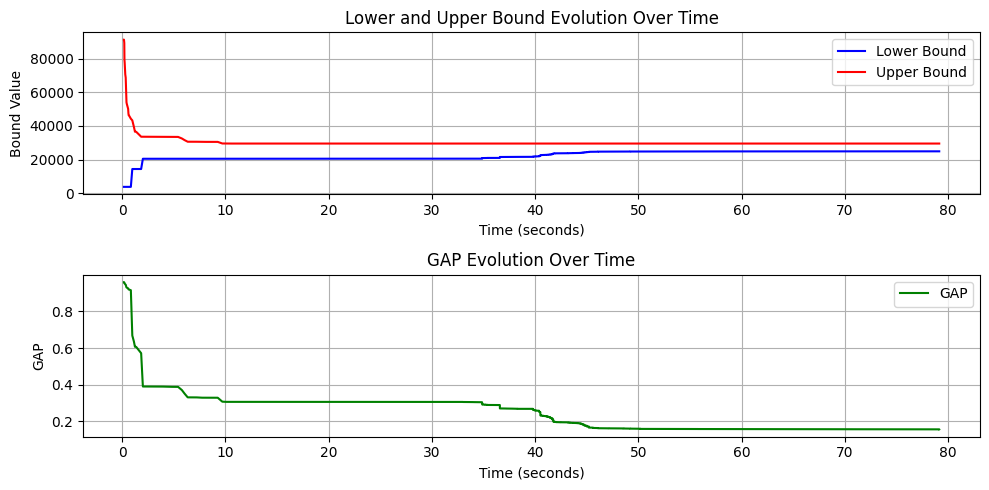

In [8]:
# Plot the results in two subplots within the same figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))  # 2 rows, 1 column

# Plot 1: Lower and Upper Bound
ax1.plot(time_list[5:], lower_bound_list[5:], label='Lower Bound', color='blue')
ax1.plot(time_list[5:], upper_bound_list[5:], label='Upper Bound', color='red')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Bound Value')
ax1.set_title('Lower and Upper Bound Evolution Over Time')
ax1.legend()
ax1.grid(True)

# Plot 2: GAP
ax2.plot(time_list[5:], gap_list[5:], label='GAP', color='green')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('GAP')
ax2.set_title('GAP Evolution Over Time')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()  # Adjusts spacing between plots
plt.show()

In [9]:
def generar_sublistas(tuplas,tuplas_iniciales):
    sublistas = []
    while tuplas_iniciales:
        sublista = []
        actual = tuplas_iniciales.pop(0)
        sublista.append(actual)
        
        # Buscar conexiones hacia adelante
        while True:
            found = False
            for i, t in enumerate(tuplas):
                if t[0] == actual[1]:
                    sublista.append(t)
                    actual = t
                    tuplas.pop(i)
                    found = True
                    break
            if not found:
                break
        
        sublistas.append(sublista)
    
    return sublistas


def hora_a_minutos(n):
    hora = str(n).split(':')
    if len(hora) == 3:
        return float(hora[0])*60 + float(hora[1])+ float(hora[2])/100
    if len(hora) == 2:
        return float(hora[0])*60 + float(hora[1])



vx = m3.getAttr('x', x)
solucion = {}
tuplas = []
tuplas_iniciales = []
contador = 1
for tupla,valor in vx.items():
    if valor >= 0.95 :
        tuplas.append(tupla)
    if valor >= 0.95 and tupla[0]==0:
        tuplas_iniciales.append(tupla)
        
resultados = generar_sublistas(tuplas,tuplas_iniciales)

for i in resultados:
    if len(i)>1:
        solucion[contador] = {0:0}
        
        solucion[contador][0]= i[0][0]
        for k in i:
            solucion[contador][k[0]]= k[1]
        contador +=1
        
print("---------------------- SOLUCION ----------------------")
print(solucion)

asignacion = pd.DataFrame()
for k in range(1,M+1):   
    nodo = 0    
    ord = []
    tiempo_anden = []
    while nodo != len(N)+1:
        tiempo_anden.append(costos[nodo,solucion[k][nodo]])
        ord.append(solucion[k][nodo])
        nodo = solucion[k][nodo]
    
    a = base[list(base.columns[0:1]) + list(base.columns[3:5]) + list(base.columns[9:10])]
    a = a[a['ORD'].isin(ord)].reset_index(drop=True)
    a['Tiempo en anden'] = pd.Series(tiempo_anden)
    a['UNIDAD ASIGNADA'] = k
    
    asignacion = pd.concat([asignacion,a])
asignacion = asignacion.sort_values(by='SALIDA')
print('---------------------- ASIGNACION FINAL ----------------------')
print(asignacion.head(10).to_markdown(index=False),'\n')


---------------------- SOLUCION ----------------------
{1: {0: 1, 1: 21, 21: 40, 40: 57, 57: 77, 77: 97, 97: 116, 116: 121}, 2: {0: 2, 2: 22, 22: 41, 41: 59, 59: 79, 79: 99, 99: 118, 118: 121}, 3: {0: 4, 4: 23, 23: 43, 43: 60, 60: 80, 80: 100, 100: 119, 119: 121}, 4: {0: 5, 5: 24, 24: 44, 44: 62, 62: 82, 82: 102, 102: 121}, 5: {0: 7, 7: 25, 25: 46, 46: 65, 65: 83, 83: 103, 103: 121}, 6: {0: 9, 9: 26, 26: 47, 47: 67, 67: 84, 84: 105, 105: 121}, 7: {0: 11, 11: 27, 27: 49, 49: 68, 68: 85, 85: 106, 106: 121}, 8: {0: 12, 12: 28, 28: 50, 50: 69, 69: 86, 86: 107, 107: 121}, 9: {0: 14, 14: 29, 29: 51, 51: 71, 71: 87, 87: 108, 108: 121}, 10: {0: 16, 16: 30, 30: 53, 53: 72, 72: 88, 88: 110, 110: 121}, 11: {0: 17, 17: 31, 31: 54, 54: 74, 74: 89, 89: 111, 111: 121}, 12: {0: 18, 18: 33, 33: 56, 56: 76, 76: 91, 91: 115, 115: 121}, 13: {0: 19, 19: 32, 32: 55, 55: 75, 75: 90, 90: 113, 113: 121}, 14: {0: 20, 20: 34, 34: 58, 58: 81, 81: 95, 95: 120, 120: 121}, 15: {0: 35, 35: 52, 52: 78, 78: 92, 92: 109

In [10]:
unidad = 1

print(f'---------------------- ASIGNACION UNIDAD {unidad} ----------------------')

resultado_individual = asignacion[asignacion['UNIDAD ASIGNADA']==unidad]
print(resultado_individual.to_markdown(index=False),'\n')

vT = m3.getAttr('x', T)
vPV = m3.getAttr('x',PV)
vY0 = m3.getAttr('x',y0)
vY1 = m3.getAttr('x',y1)
vY2 = m3.getAttr('x',y2)

solucion = {}
tuplas = []
contador = 1

print(f'---------------------- VARIABLES MODELO ----------------------')

for i in resultado_individual['ORD'].to_list():
    print(f"Nodo {i}, T: {vT[i]}, P: {vPV[i]}, y0: {vY0[i]}, y1: {vY1[i]}, y2: {vY2[i]}")

---------------------- ASIGNACION UNIDAD 1 ----------------------
|   ORD |   SALIDA |   LLEGADA |   Tiempo en anden |   UNIDAD ASIGNADA |
|------:|---------:|----------:|------------------:|------------------:|
|     1 |      300 |       408 |                 0 |                 1 |
|    21 |      413 |       528 |                 5 |                 1 |
|    40 |      571 |       686 |                43 |                 1 |
|    57 |      690 |       805 |                 4 |                 1 |
|    77 |      809 |       924 |                 4 |                 1 |
|    97 |      968 |      1083 |                44 |                 1 |
|   116 |     1090 |      1205 |                 7 |                 1 | 

---------------------- VARIABLES MODELO ----------------------
Nodo 1, T: 108.0, P: 0.0, y0: 1.0, y1: 0.0, y2: 0.0
Nodo 21, T: 228.0, P: 0.0, y0: 1.0, y1: 0.0, y2: 0.0
Nodo 40, T: 386.0, P: 1.0, y0: 0.0, y1: 1.0, y2: 0.0
Nodo 57, T: 505.0, P: 1.0, y0: 0.0, y1: 1.0, y2: 0.0
N

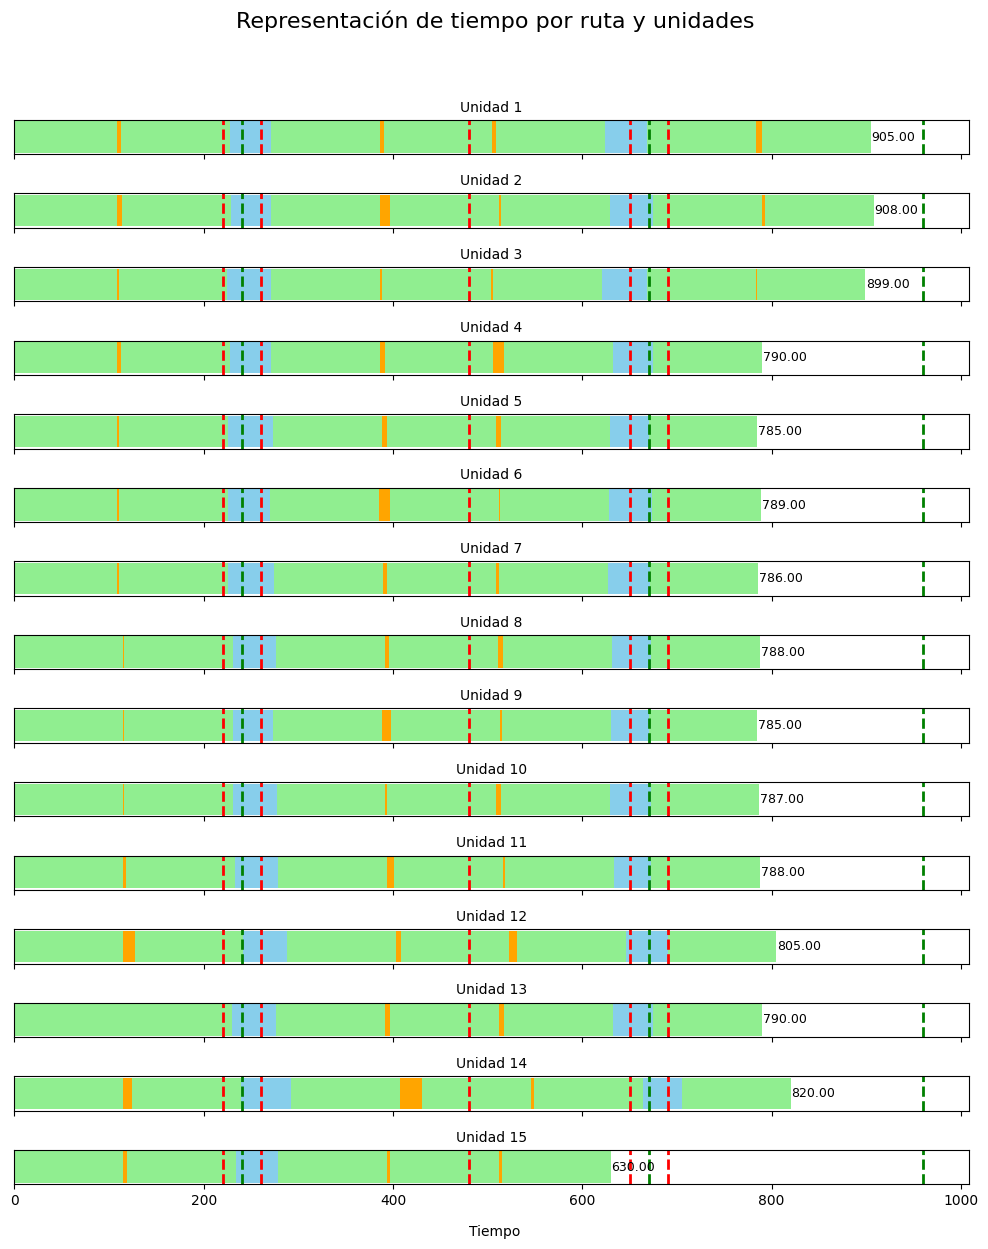

In [11]:
import matplotlib.pyplot as plt

asignacion['TIEMPO_VIAJE'] = asignacion['LLEGADA'] - asignacion['SALIDA']

# Valor umbral para cambiar de color
valor_umbral = u1

# Obtener las unidades únicas
unidades = asignacion['UNIDAD ASIGNADA'].unique()

# Crear un subgráfico por cada unidad
fig, axs = plt.subplots(len(unidades), 1, figsize=(10, len(unidades)*1/1.15), sharex=True)  # Ajustar el tamaño del gráfico

# Valores para las líneas verticales

lineas_verticales_exacto = [break1,break2,break3]
lineas_verticales = [break1-P/2, break1+P/2, 480, break2-P/2, break2+P/2]

for i, unidad in enumerate(unidades):
    asignacion_unidad = asignacion[asignacion['UNIDAD ASIGNADA'] == unidad]
    
    Type = []
    Time = []
    Colors = []
    for j, row in asignacion_unidad.iterrows():
        if not np.isnan(row['Tiempo en anden']):
            Type.append('A1')
            Time.append(row['Tiempo en anden'])
            # Asignar color según el valor del tiempo en andén
            if row['Tiempo en anden'] <= valor_umbral:
                Colors.append('orange')
            else:
                Colors.append('skyblue')
        Type.append('A2')
        Time.append(row['TIEMPO_VIAJE'])
        Colors.append('lightgreen')  # Color fijo para A2
    
    data = pd.DataFrame({
        "Type": Type,
        "Time": Time,
        "Colors": Colors
    })
    
    left = 0
    bar_height = 0.3  # Ajustar el ancho de las barras
    for idx, row in data.iterrows():
        axs[i].barh(y=0, width=row['Time'], left=left, color=row['Colors'], height=bar_height)
        left += row['Time']
    
    # Añadir el texto al final de la barra
    total_time = left  # La longitud total de la barra es 'left' después del bucle
    axs[i].text(left + 0.5, 0, f'{total_time:.2f}', va='center', fontsize=9)  # Ajusta 0.5 para dar espacio al texto
    
    axs[i].set_yticks([])
    axs[i].set_title(f'Unidad {unidad}', fontsize=10)

    # Añadir líneas verticales rojas en los valores especificados
    for x_value in lineas_verticales:
        axs[i].axvline(x=x_value, color='red', linestyle='--', linewidth=2)
    for x_value in lineas_verticales_exacto:
        axs[i].axvline(x=x_value, color='green', linestyle='--', linewidth=2)

# Etiquetas comunes
fig.text(0.5, 0.04, 'Tiempo', ha='center')
fig.suptitle('Representación de tiempo por ruta y unidades', fontsize=16)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show() 

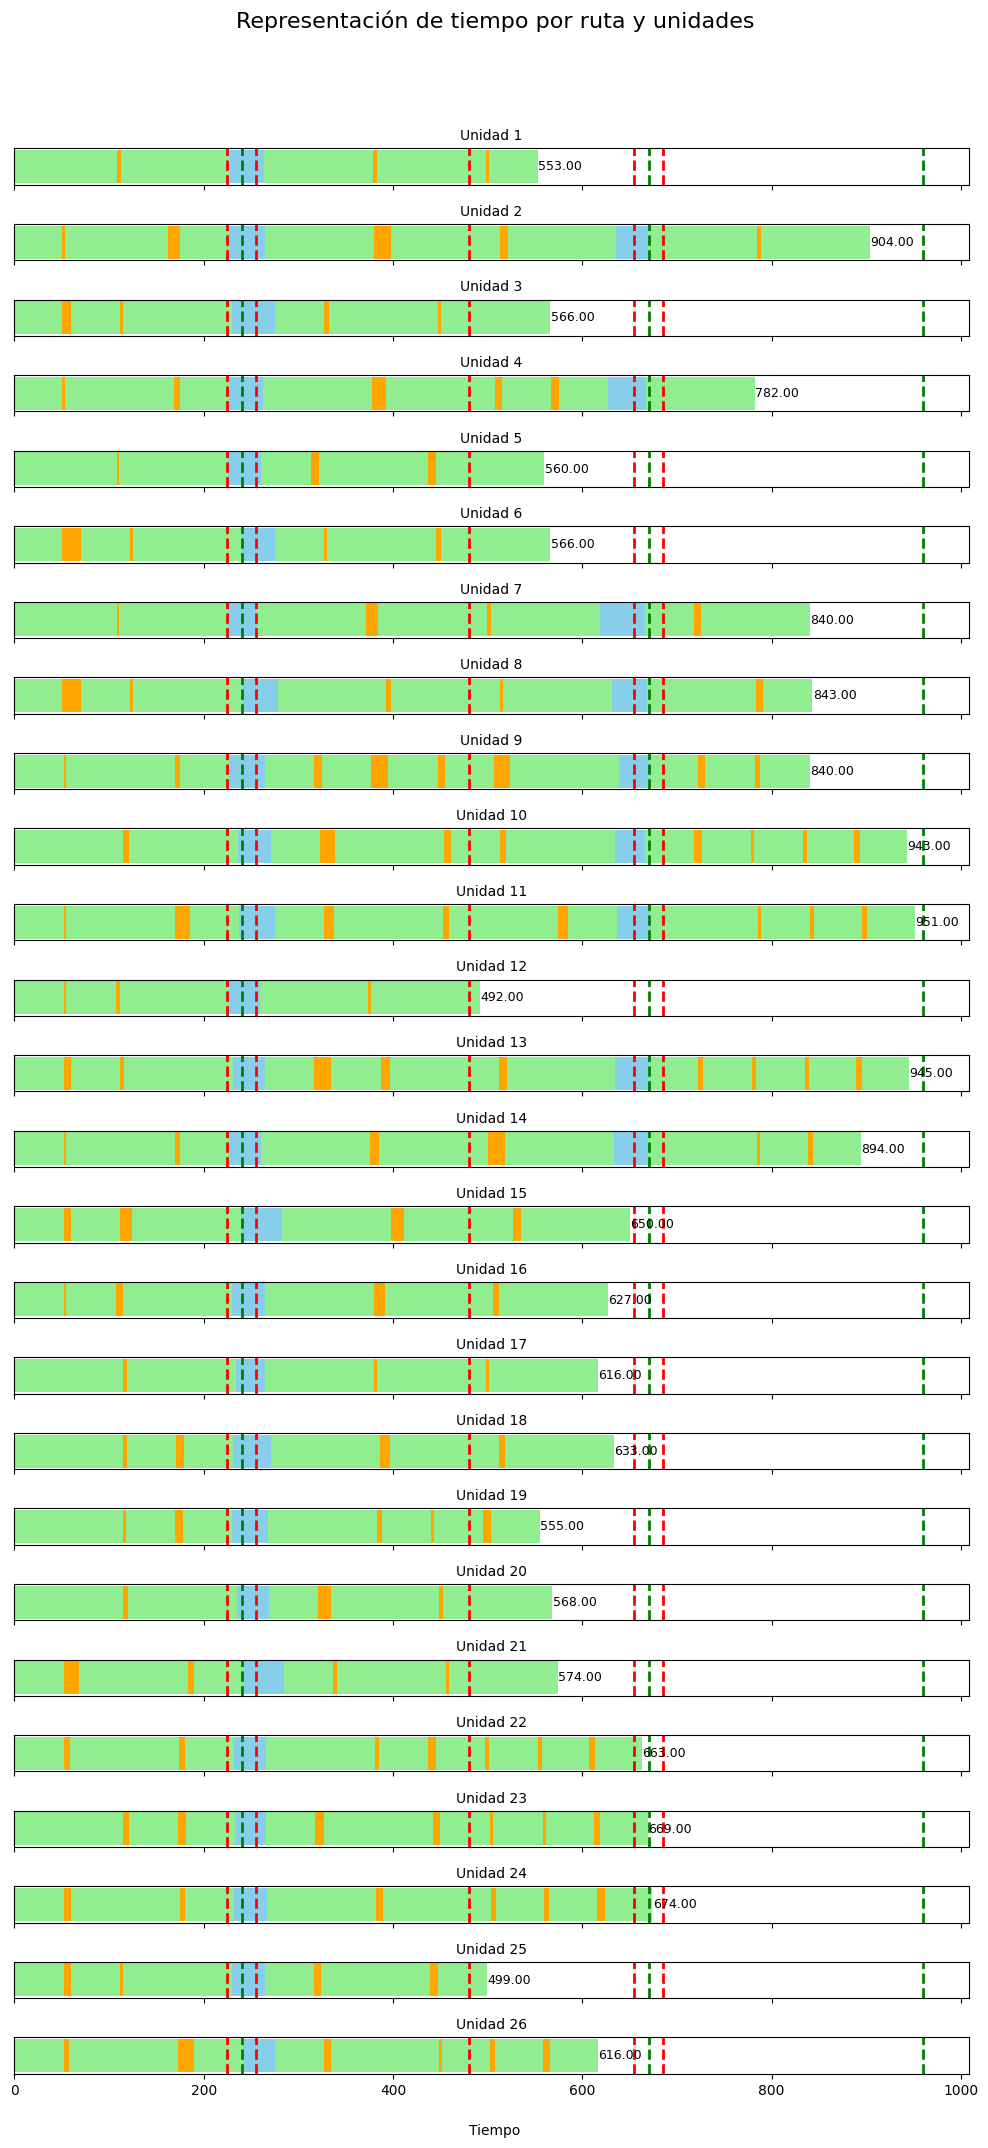

In [88]:
import matplotlib.pyplot as plt

asignacion['TIEMPO_VIAJE'] = asignacion['LLEGADA'] - asignacion['SALIDA']

# Valor umbral para cambiar de color
valor_umbral = u1

# Obtener las unidades únicas
unidades = asignacion['UNIDAD ASIGNADA'].unique()

# Crear un subgráfico por cada unidad
fig, axs = plt.subplots(len(unidades), 1, figsize=(10, len(unidades)*1/1.15), sharex=True)  # Ajustar el tamaño del gráfico

# Valores para las líneas verticales

lineas_verticales_exacto = [break1,break2,break3]
lineas_verticales = [break1-P/2, break1+P/2, 480, break2-P/2, break2+P/2]

for i, unidad in enumerate(unidades):
    asignacion_unidad = asignacion[asignacion['UNIDAD ASIGNADA'] == unidad]
    
    Type = []
    Time = []
    Colors = []
    for j, row in asignacion_unidad.iterrows():
        if not np.isnan(row['Tiempo en anden']):
            Type.append('A1')
            Time.append(row['Tiempo en anden'])
            # Asignar color según el valor del tiempo en andén
            if row['Tiempo en anden'] <= valor_umbral:
                Colors.append('orange')
            else:
                Colors.append('skyblue')
        Type.append('A2')
        Time.append(row['TIEMPO_VIAJE'])
        Colors.append('lightgreen')  # Color fijo para A2
    
    data = pd.DataFrame({
        "Type": Type,
        "Time": Time,
        "Colors": Colors
    })
    
    left = 0
    bar_height = 0.3  # Ajustar el ancho de las barras
    for idx, row in data.iterrows():
        axs[i].barh(y=0, width=row['Time'], left=left, color=row['Colors'], height=bar_height)
        left += row['Time']
    
    # Añadir el texto al final de la barra
    total_time = left  # La longitud total de la barra es 'left' después del bucle
    axs[i].text(left + 0.5, 0, f'{total_time:.2f}', va='center', fontsize=9)  # Ajusta 0.5 para dar espacio al texto
    
    axs[i].set_yticks([])
    axs[i].set_title(f'Unidad {unidad}', fontsize=10)

    # Añadir líneas verticales rojas en los valores especificados
    for x_value in lineas_verticales:
        axs[i].axvline(x=x_value, color='red', linestyle='--', linewidth=2)
    for x_value in lineas_verticales_exacto:
        axs[i].axvline(x=x_value, color='green', linestyle='--', linewidth=2)

# Etiquetas comunes
fig.text(0.5, 0.04, 'Tiempo', ha='center')
fig.suptitle('Representación de tiempo por ruta y unidades', fontsize=16)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show() 

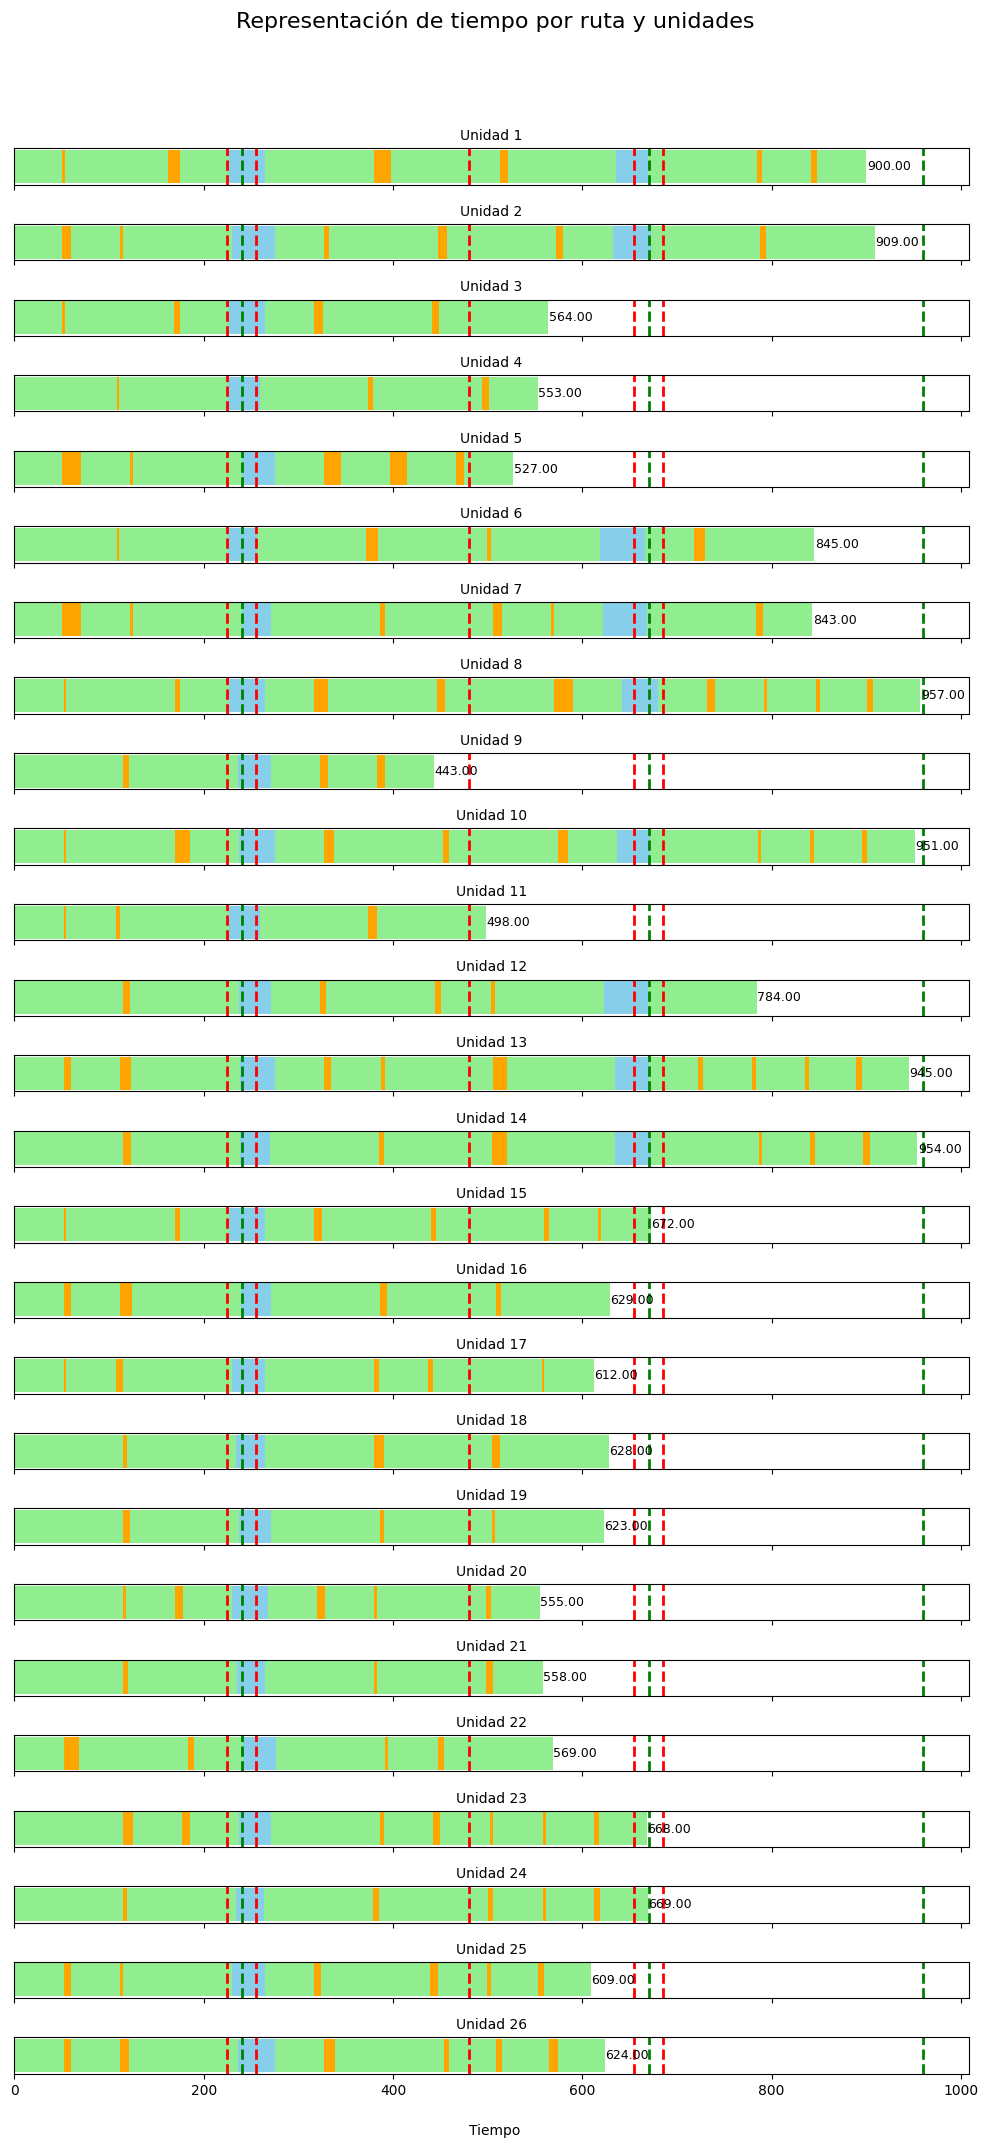

In [39]:
import matplotlib.pyplot as plt

asignacion['TIEMPO_VIAJE'] = asignacion['LLEGADA'] - asignacion['SALIDA']

# Valor umbral para cambiar de color
valor_umbral = u1

# Obtener las unidades únicas
unidades = asignacion['UNIDAD ASIGNADA'].unique()

# Crear un subgráfico por cada unidad
fig, axs = plt.subplots(len(unidades), 1, figsize=(10, len(unidades)*1/1.15), sharex=True)  # Ajustar el tamaño del gráfico

# Valores para las líneas verticales

lineas_verticales_exacto = [break1,break2,break3]
lineas_verticales = [break1-P/2, break1+P/2, 480, break2-P/2, break2+P/2]

for i, unidad in enumerate(unidades):
    asignacion_unidad = asignacion[asignacion['UNIDAD ASIGNADA'] == unidad]
    
    Type = []
    Time = []
    Colors = []
    for j, row in asignacion_unidad.iterrows():
        if not np.isnan(row['Tiempo en anden']):
            Type.append('A1')
            Time.append(row['Tiempo en anden'])
            # Asignar color según el valor del tiempo en andén
            if row['Tiempo en anden'] <= valor_umbral:
                Colors.append('orange')
            else:
                Colors.append('skyblue')
        Type.append('A2')
        Time.append(row['TIEMPO_VIAJE'])
        Colors.append('lightgreen')  # Color fijo para A2
    
    data = pd.DataFrame({
        "Type": Type,
        "Time": Time,
        "Colors": Colors
    })
    
    left = 0
    bar_height = 0.3  # Ajustar el ancho de las barras
    for idx, row in data.iterrows():
        axs[i].barh(y=0, width=row['Time'], left=left, color=row['Colors'], height=bar_height)
        left += row['Time']
    
    # Añadir el texto al final de la barra
    total_time = left  # La longitud total de la barra es 'left' después del bucle
    axs[i].text(left + 0.5, 0, f'{total_time:.2f}', va='center', fontsize=9)  # Ajusta 0.5 para dar espacio al texto
    
    axs[i].set_yticks([])
    axs[i].set_title(f'Unidad {unidad}', fontsize=10)

    # Añadir líneas verticales rojas en los valores especificados
    for x_value in lineas_verticales:
        axs[i].axvline(x=x_value, color='red', linestyle='--', linewidth=2)
    for x_value in lineas_verticales_exacto:
        axs[i].axvline(x=x_value, color='green', linestyle='--', linewidth=2)

# Etiquetas comunes
fig.text(0.5, 0.04, 'Tiempo', ha='center')
fig.suptitle('Representación de tiempo por ruta y unidades', fontsize=16)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()